## Load Python Libraries, Model Configurations, Model Checkpoints and Dataset

In [3]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.special import softmax

# PyTorch
import torch

# Configuration
from omegaconf import OmegaConf

# Visualization
import seaborn as sns

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler

# RDKit core and general chemistry modules
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, Draw, BRICS, Recap, rdReducedGraphs
from rdkit.Chem.rdmolops import FastFindRings
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.rdMolDescriptors import *

# DeepChem
from deepchem.utils.typing import RDKitMol
from deepchem.feat.base_classes import MolecularFeaturizer

# Local imports
from src.model.arcfdi import ArcDFI

conf = OmegaConf.load('./src/settings.yaml')['arcdfi']
model = ArcDFI.Model.load_from_checkpoint('./ArcDFI/checkpoints/arcdfi.ckpt', strict=True, conf=conf)
df = pd.read_csv('./ArcDFI/datasets/dfi_final.csv', index_col=0)

/tmp/ipykernel_3907286/2612462338.py:36: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./ArcDFI/datasets/dfi_final.csv', index_col=0)


## Data Processing Code for Model Inference 

In [4]:
FEAT2DIM   = dict(morgan=1024,pharma=39972,maccs=167,erg=441,pubchem=881)

def check_compound_sanity(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles) 
        return True if mol else False
    except:
        return False

def create_morgan_fingerprint(smiles, mol=None):
    if mol == None:
        mol = Chem.MolFromSmiles(smiles)
    mol.UpdatePropertyCache()
    FastFindRings(mol)

    return np.array(AllChem.GetMorganFingerprintAsBitVect(mol,2, nBits=1024)).reshape(1,-1)

def create_pharma_fingerprint(smiles, mol=None):
    if mol == None:
        mol = Chem.MolFromSmiles(smiles)
    mol.UpdatePropertyCache()
    FastFindRings(mol)

    return np.array(Generate.Gen2DFingerprint(mol, Gobbi_Pharm2D.factory)).reshape(1,-1)

def create_maccs_fingerprint(smiles, mol=None):
    if mol == None:
        mol = Chem.MolFromSmiles(smiles)
    mol.UpdatePropertyCache()

    return np.array(GetMACCSKeysFingerprint(mol)).reshape(1,-1)

def create_erg_fingerprint(smiles, mol=None):
    if mol == None:
        mol = Chem.MolFromSmiles(smiles)
    mol.UpdatePropertyCache()
    
    return np.array(rdReducedGraphs.GetErGFingerprint(mol)).reshape(1,-1)

def get_all_compound_features(dcomp_smiles, fcomp_smiles, dcomp_mol=None, fcomp_mol=None):
        try:
            return dict(
                dcomp_morgan_fp=create_morgan_fingerprint(dcomp_smiles, dcomp_mol),
                dcomp_maccs_fp=create_maccs_fingerprint(dcomp_smiles, dcomp_mol),
                dcomp_erg_fp=create_erg_fingerprint(dcomp_smiles, dcomp_mol),
                fcomp_morgan_fp=create_morgan_fingerprint(fcomp_smiles, fcomp_mol),
                fcomp_maccs_fp=create_maccs_fingerprint(fcomp_smiles, fcomp_mol),
                fcomp_erg_fp=create_erg_fingerprint(fcomp_smiles, fcomp_mol)
                )
        except Exception as e:
            print(e)
            return None

def tokenize(matrix, padding_idx=1024):
    tokenized_indices = [torch.nonzero(row).squeeze(1) for row in matrix]
    max_length        = max(len(indices) for indices in tokenized_indices)
    padded_tensor = torch.full((len(tokenized_indices), max_length), fill_value=padding_idx)

    for i, indices in enumerate(tokenized_indices):
        padded_tensor[i, :len(indices)] = indices

    padding_mask = (padded_tensor != padding_idx).float()

    assert padded_tensor.shape[1] == padding_mask.shape[1]

    return padded_tensor, padding_mask

def get_substructures_morgan(comp_smiles):
    mol = Chem.MolFromSmiles(comp_smiles)
    if mol == None:
        mol = Chem.MolFromSmiles(comp_smiles)
    mol.UpdatePropertyCache()
    FastFindRings(mol)

    bitInfo = {}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol,2, nBits=1024, bitInfo=bitInfo)

    highlight_atoms ={ }
    
    substructures = {}
    for bit, atoms_radius in bitInfo.items():
        for atom_idx, rad in atoms_radius:
            # Create a substructure (submol) containing the atoms associated with the bit
            env = Chem.FindAtomEnvironmentOfRadiusN(mol, rad, atom_idx)
            atoms = set()
            for bond in env:
                atoms.add(mol.GetBondWithIdx(bond).GetBeginAtomIdx())
                atoms.add(mol.GetBondWithIdx(bond).GetEndAtomIdx())
            
            # Create the substructure (submol) for these atoms
            submol = Chem.PathToSubmol(mol, env)
            smiles_substructure = Chem.MolToSmiles(submol)
            # print(env,submol)
            # Store the substructure SMILES with its corresponding bit
            substructures[bit%1024] = smiles_substructure

            # For visualization
            matches = mol.GetSubstructMatches(submol)
            if smiles_substructure != '':
                highlight_atoms[bit%1024] = [i for match in matches for i in match] 
    
    return substructures, highlight_atoms, mol

def make_inference_data(**kwargs):
    data_instance                      = get_all_compound_features(kwargs['drugcompound_smiles'], kwargs['foodcompound_smiles'])
    data_instance['pair_id']           = kwargs['drugcompound_id'] + ' & ' + kwargs['foodcompound_id']
    data_instance['dcomp_id']          = kwargs['drugcompound_id']
    data_instance['fcomp_id']          = kwargs['foodcompound_id']
    data_instance['dcomp_smiles']      = kwargs['drugcompound_smiles']
    data_instance['fcomp_smiles']      = kwargs['foodcompound_smiles']
    data_instance['y_dfi_label']       = np.array([0])
    data_instance['dcomp_dci_labels']  = np.zeros(10).reshape(1,-1)
    data_instance['dcomp_dci_masks']   = np.zeros(10).reshape(1,-1)

    input_dict                         = dict()
    input_dict['dcomp_id']             = [data_instance['dcomp_id']]
    input_dict['fcomp_id']             = [data_instance['fcomp_id']]
    input_dict['dcomp_smiles']         = [data_instance['dcomp_smiles']]
    input_dict['fcomp_smiles']         = [data_instance['fcomp_smiles']]
    
    input_dict['dcomp_morgan_fp']      = torch.tensor(data=data_instance['dcomp_morgan_fp'],dtype=torch.float32)
    input_dict['dcomp_maccs_fp']       = torch.tensor(data=data_instance['dcomp_maccs_fp'], dtype=torch.float32)
    input_dict['dcomp_erg_fp']         = torch.tensor(data=data_instance['dcomp_erg_fp'],   dtype=torch.float32)
    input_dict['fcomp_morgan_fp']      = torch.tensor(data=data_instance['fcomp_morgan_fp'],dtype=torch.float32)
    input_dict['fcomp_maccs_fp']       = torch.tensor(data=data_instance['fcomp_maccs_fp'], dtype=torch.float32)
    input_dict['fcomp_erg_fp']         = torch.tensor(data=data_instance['fcomp_erg_fp'],   dtype=torch.float32)
    
    input_dict['dcomp_morgan_words'], input_dict['dcomp_morgan_masks'] = tokenize(input_dict['dcomp_morgan_fp'], FEAT2DIM['morgan'])
    input_dict['dcomp_maccs_words'],  input_dict['dcomp_maccs_masks']  = tokenize(input_dict['dcomp_maccs_fp'], FEAT2DIM['maccs'])
    input_dict['dcomp_erg_words'],    input_dict['dcomp_erg_masks']    = tokenize(input_dict['dcomp_erg_fp'], FEAT2DIM['erg'])
    input_dict['fcomp_morgan_words'], input_dict['fcomp_morgan_masks'] = tokenize(input_dict['fcomp_morgan_fp'], FEAT2DIM['morgan'])
    input_dict['fcomp_maccs_words'],  input_dict['fcomp_maccs_masks']  = tokenize(input_dict['fcomp_maccs_fp'], FEAT2DIM['maccs'])
    input_dict['fcomp_erg_words'],    input_dict['fcomp_erg_masks']    = tokenize(input_dict['fcomp_erg_fp'], FEAT2DIM['erg'])  
    
    input_dict['y_dfi_label']      = torch.tensor(data=data_instance['y_dfi_label'],      dtype=torch.float32)
    input_dict['dcomp_dci_labels'] = torch.tensor(data=data_instance['dcomp_dci_labels'], dtype=torch.float32)
    input_dict['dcomp_dci_masks']  = torch.tensor(data=data_instance['dcomp_dci_masks'],  dtype=torch.float32)

    return input_dict

## Visualization Code for Attention Weights Analysis

In [5]:

def visualize_attention_weights(compound_name, attention_weights, substructures, interaction_type, highlight_atoms):
    singular_atoms = []
    substruct_labels = []
    highlight_selected = []
    for idx, jdx in enumerate(sorted(substructures.keys())):
        if substructures[jdx] == '':
            singular_atoms.append(idx)
        else:
            substruct_labels.append(substructures[jdx])
            highlight_selected.append(highlight_atoms[jdx])
    
    attention_weights = np.delete(attention_weights, singular_atoms, axis=1)
    
    rows = attention_weights.shape[0]*1.1
    cols = attention_weights.shape[1]*1.1
    
    actual_weight = attention_weights[:,:-10]
    pseudo_weight = 1. - attention_weights[:,-10:].sum(1).reshape(-1,1)

    mMscaler = MinMaxScaler()
    actual_weight = mMscaler.fit_transform(actual_weight.T).T
    actual_weight = softmax(actual_weight, axis=1)
    actual_weight = actual_weight / actual_weight.sum(1).reshape(-1,1)

    attention_weights = np.hstack([actual_weight, pseudo_weight])
    mask = np.zeros_like(attention_weights, dtype=bool)
    mask[:, -1] = True 


    colors1 = [(0, 0, 1), (1, 0, 0)]  # Blue to Red
    colors2 = [(1, 1, 1), (0, 0, 0)]  # White to Black
    cmap1 = LinearSegmentedColormap.from_list("BlueToRed", colors1, N=128)
    cmap2 = LinearSegmentedColormap.from_list("WhiteToBlack", colors2, N=128)
    
    fig, ax = plt.subplots(figsize=(cols, rows))
    
    sns.heatmap(attention_weights, 
                mask=mask, 
                cmap='Blues', 
                square=True, 
                cbar=False, 
                annot=True, 
                annot_kws={"fontsize":24},
                fmt=".2f", 
                xticklabels=substruct_labels,
                yticklabels=['CYP1A2','CYP3A4','CYP2C9','CYP2C19','CYP2D6'],
                vmin=actual_weight.min(), 
                vmax=actual_weight.max(), 
                ax=ax,  
                linewidths=0.5, 
                linecolor='gray')
    sns.heatmap(attention_weights, 
                mask=~mask, 
                cmap='Reds', 
                square=True, 
                cbar=False, 
                annot=True, 
                annot_kws={"fontsize":24},
                fmt=".2f", 
                xticklabels=substruct_labels,
                yticklabels=['CYP1A2','CYP3A4','CYP2C9','CYP2C19','CYP2D6'],
                vmin=0.0, 
                vmax=1.0, 
                ax=ax, 
                linewidths=0.5, 
                linecolor='gray')
    
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=48, rotation=360)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=48, rotation=90) 
    ax.set_title(f'Attention Weights from {interaction_type}-related Head for {compound_name}', fontsize=36)

    top3_substructures = actual_weight.mean(0).argsort()[-2:]

    top3_substruct_labels = np.array(substruct_labels)[top3_substructures]
    top3_atom_highlights  = []
    for i in top3_substructures:
        top3_atom_highlights.extend(highlight_selected[i])

    return top3_substruct_labels, top3_atom_highlights

def draw_molecule(file_name, mol, highlight_atoms):
    drawer = rdMolDraw2D.MolDraw2DCairo(400, 400)  
    opts = drawer.drawOptions()
    opts.highlightAtomColors = {i: (1, 0, 0) for i in highlight_atoms}  
    drawer.DrawMolecule(mol, highlightAtoms=highlight_atoms)
    drawer.FinishDrawing()    
    with open(f"{file_name}.png", "wb") as f:
        f.write(drawer.GetDrawingText())

def dfi_analysis(ext_drug, ext_food):
    print(ext_drug)
    print(ext_food)
    
    ext_drug_substructures, ext_drug_atomhighlights, mol_drug = get_substructures_morgan(ext_drug[1])
    ext_food_substructures, ext_food_atomhighlights, mol_food = get_substructures_morgan(ext_food[1])
    
    input_dict = make_inference_data(drugcompound_id='EXT-DC000001', 
                                     foodcompound_id='EXT-FC000001',
                                     drugcompound_smiles=ext_drug[1],
                                     foodcompound_smiles=ext_food[1])

    attn_weights = dict()
    model.eval()
    model.freeze()
    output_dict = model.infer(input_dict)
    
    print(output_dict['yhat_dfi'])
    
    attn_weights['dcomp_sub'] = output_dict['dcomp_attn_weights'][0,:,:].detach().cpu().numpy()
    attn_weights['dcomp_inh'] = output_dict['dcomp_attn_weights'][1,:,:].detach().cpu().numpy()
    attn_weights['fcomp_sub'] = output_dict['fcomp_attn_weights'][0,:,:].detach().cpu().numpy()
    attn_weights['fcomp_inh'] = output_dict['fcomp_attn_weights'][1,:,:].detach().cpu().numpy()

    top3_tuple = visualize_attention_weights(ext_drug[0], attn_weights['dcomp_sub'], ext_drug_substructures, 'Substrate', ext_drug_atomhighlights)
    draw_molecule(ext_drug[1]+'_dcomp_sub',mol_drug,top3_tuple[-1])
    top3_tuple = visualize_attention_weights(ext_food[0], attn_weights['fcomp_sub'], ext_food_substructures, 'Substrate', ext_food_atomhighlights)
    draw_molecule(ext_food[1]+'_fcomp_sub',mol_food,top3_tuple[-1])
    top3_tuple = visualize_attention_weights(ext_drug[0], attn_weights['dcomp_inh'], ext_drug_substructures, 'Inhibition', ext_drug_atomhighlights)
    draw_molecule(ext_drug[1]+'_dcomp_inh',mol_drug,top3_tuple[-1])
    top3_tuple = visualize_attention_weights(ext_food[0], attn_weights['fcomp_inh'], ext_food_substructures, 'Inhibition', ext_food_atomhighlights)
    draw_molecule(ext_food[1]+'_fcomp_inh',mol_food,top3_tuple[-1])


## In-house Drug-Food Compound Pair: Sulfonylurea and Salicylate

('Sulfonylurea', 'NC(=O)N=S(=O)=O.NC(=O)N=S(=O)=O')
('Salicylate', 'O=C(O)c1ccccc1[O-]')
tensor([0.3864], device='cuda:0')


'\nSulfonylurea\nSalicylate\n'

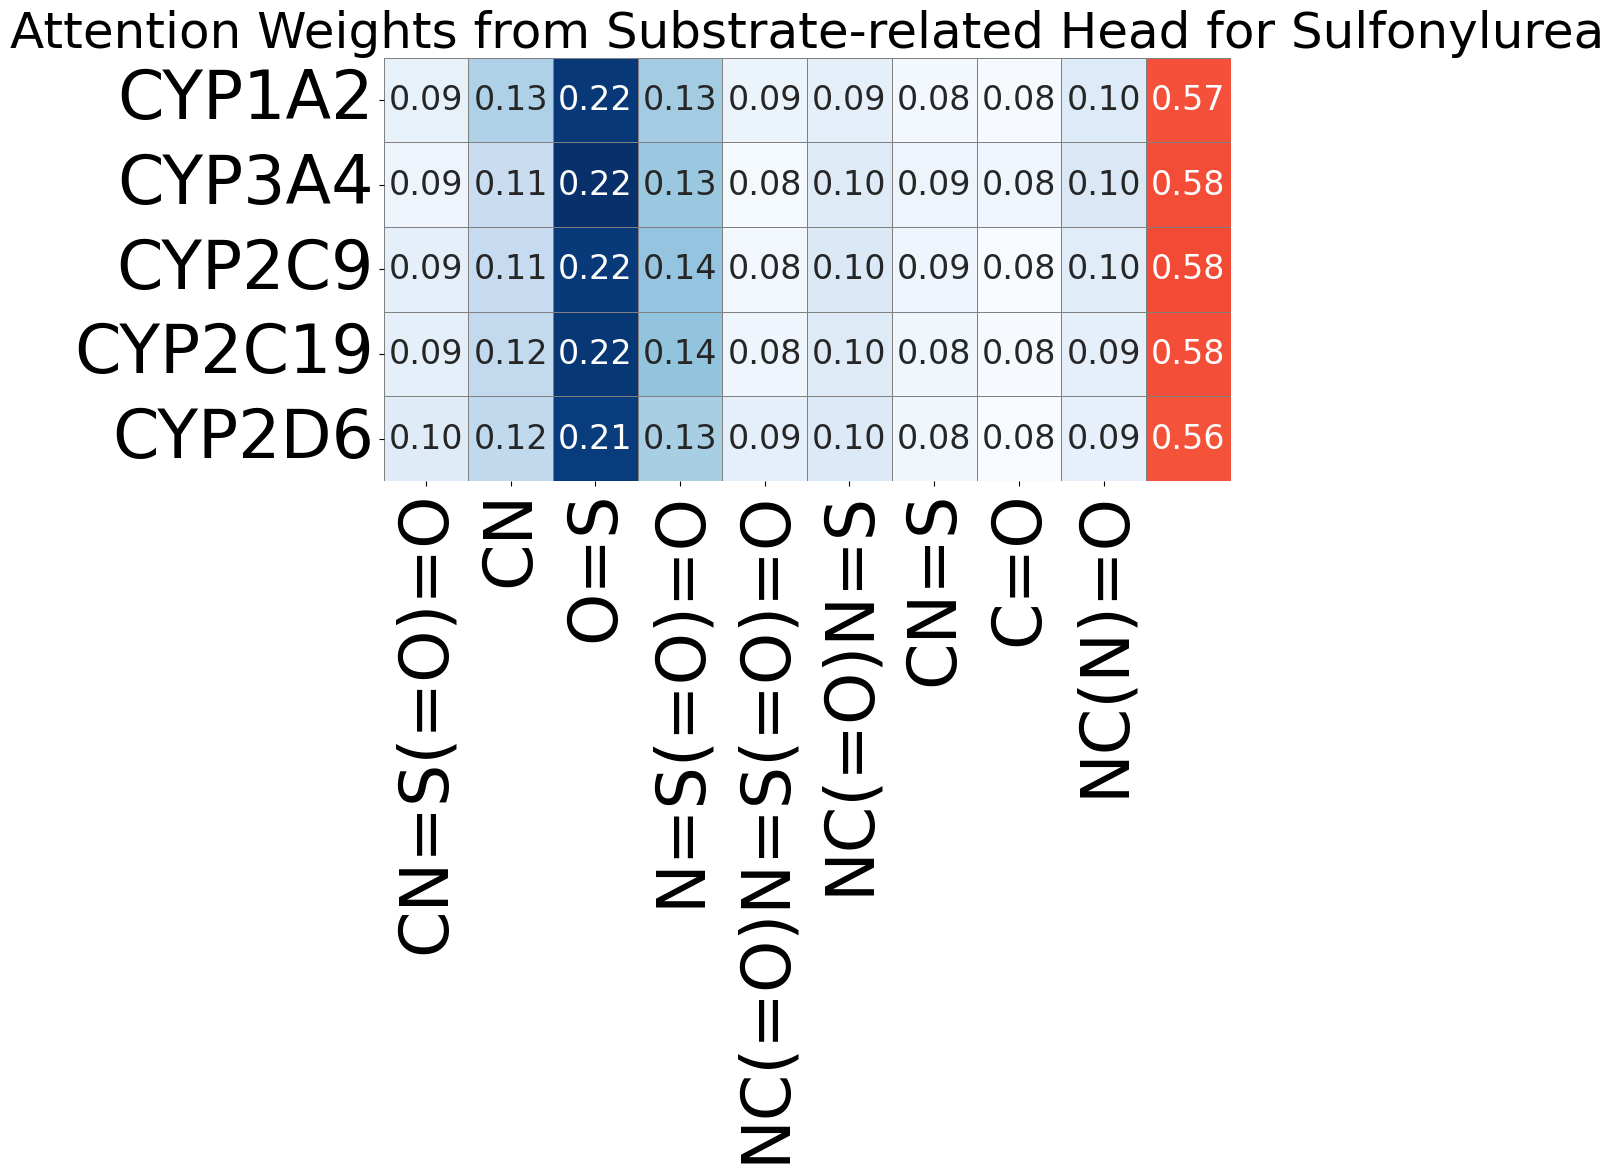

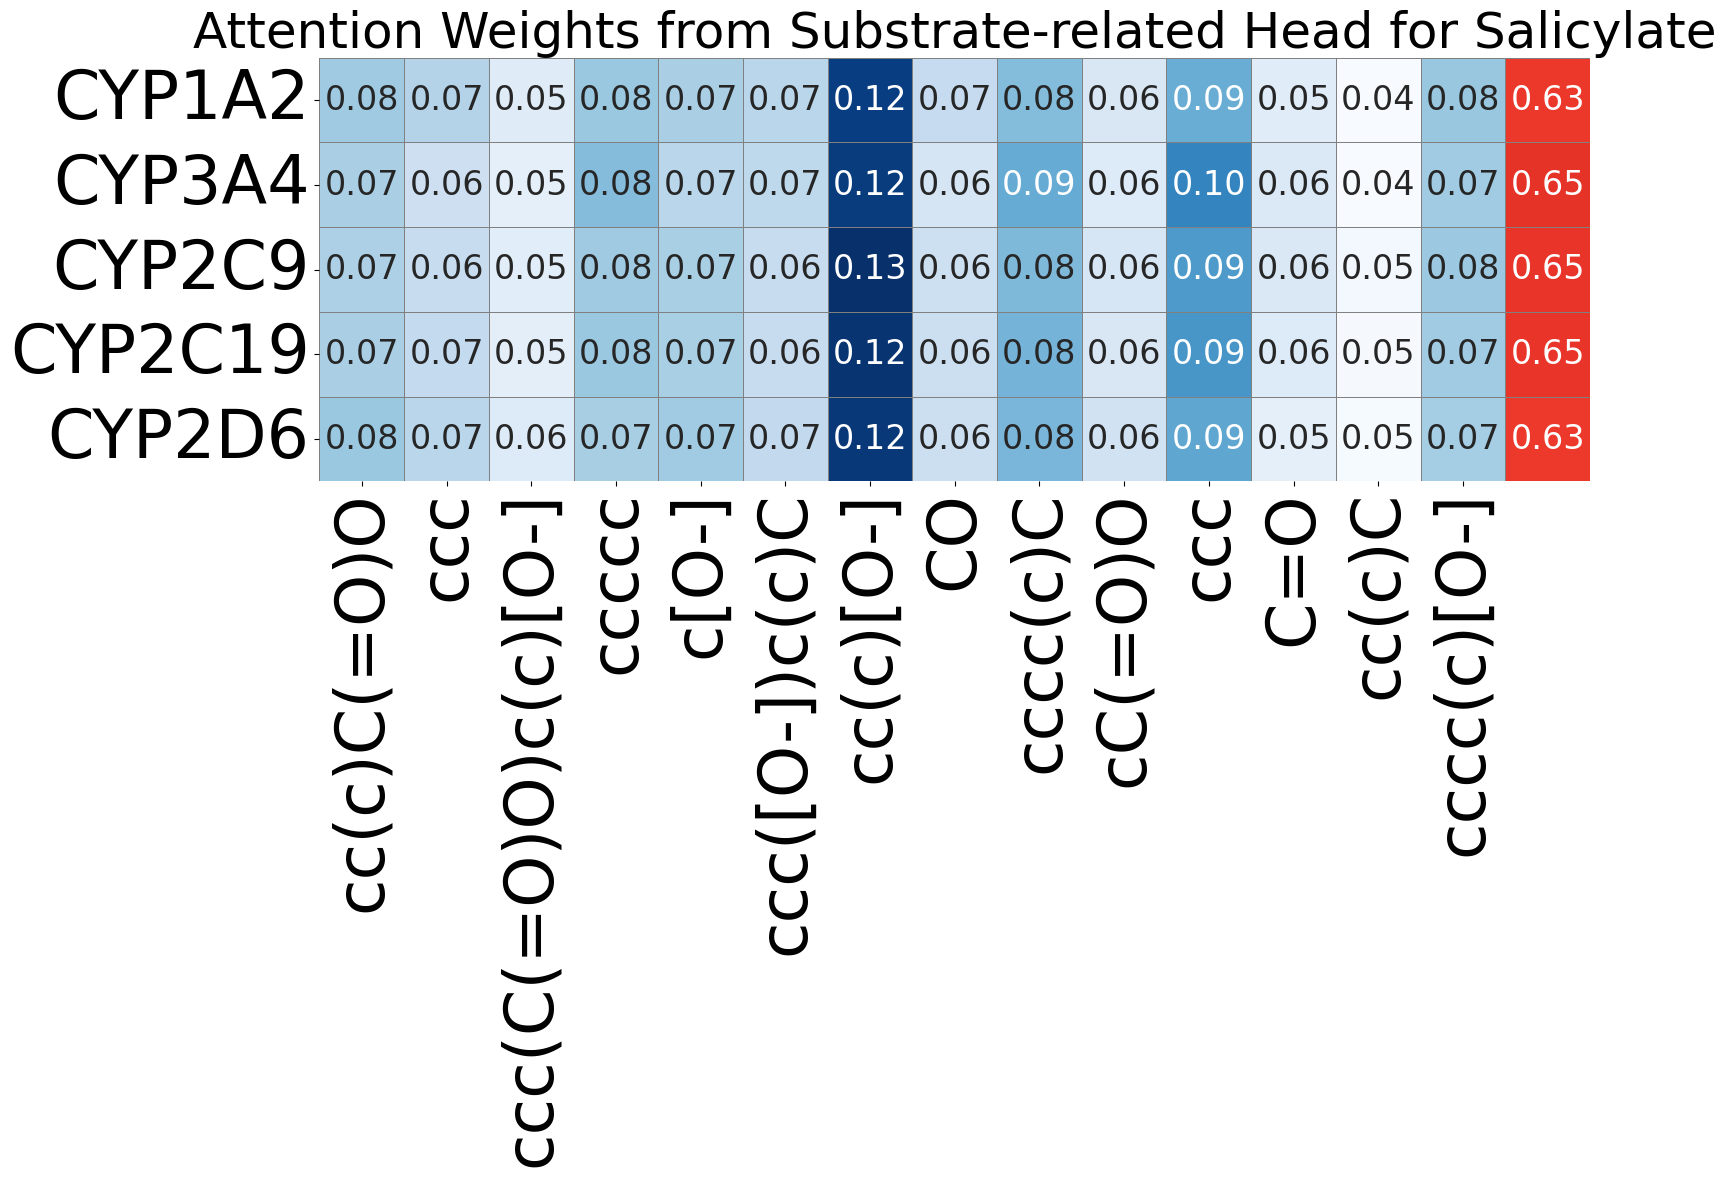

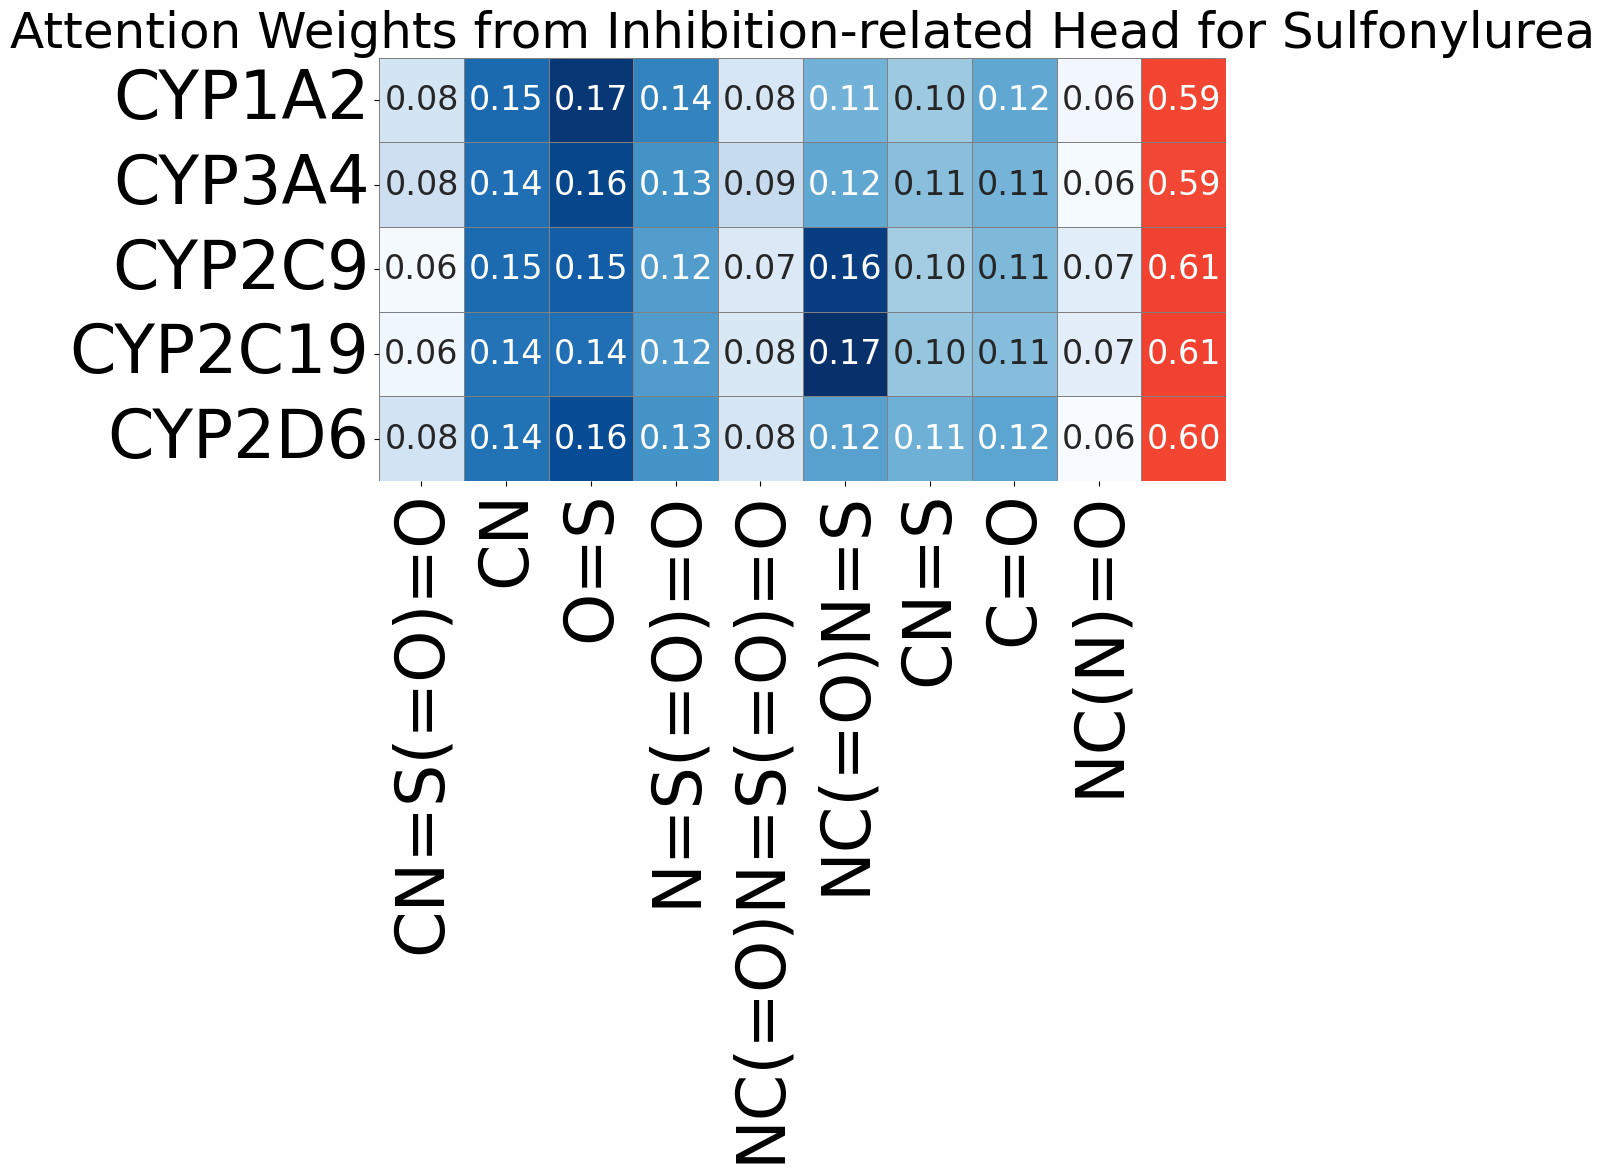

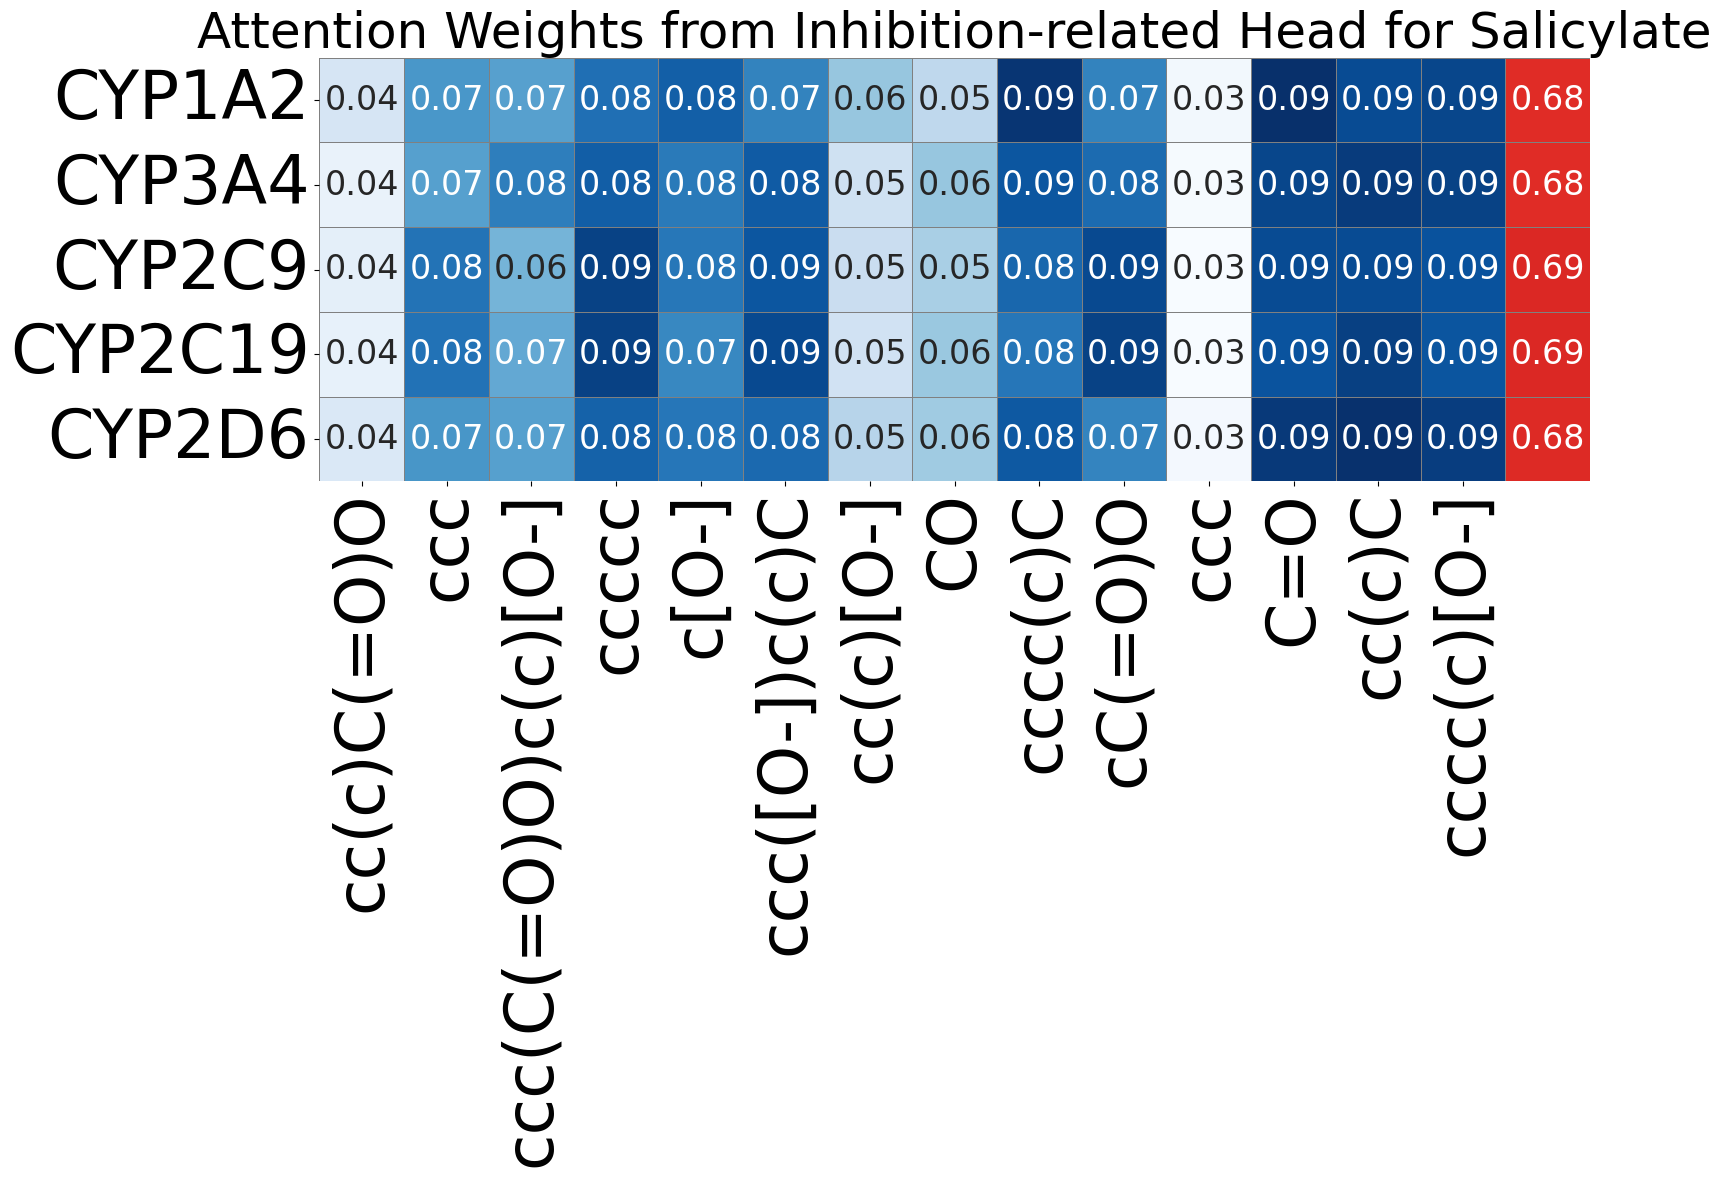

In [6]:
idx = 85
dfi_analysis(('Sulfonylurea',df[(df.split_newdrug=='test') & (df.dfi_label)].iloc[idx,:].drugcompound_smiles),
             ('Salicylate',  df[(df.split_newdrug=='test') & (df.dfi_label)].iloc[idx,:].foodcompound_smiles))

'''
Sulfonylurea
Salicylate
'''

## External Drug-Food Compound Pair: Midazolam and Berberine 

('Midazolam', 'CC1=NC=C2N1C3=C(C=C(C=C3)Cl)C(=NC2)C4=CC=CC=C4F')
('Berberine', 'COC1=C(C2=C(CC3C4=CC5=C(C=C4CCN3C2)OCO5)C=C1)OC')
tensor([0.4734], device='cuda:0')


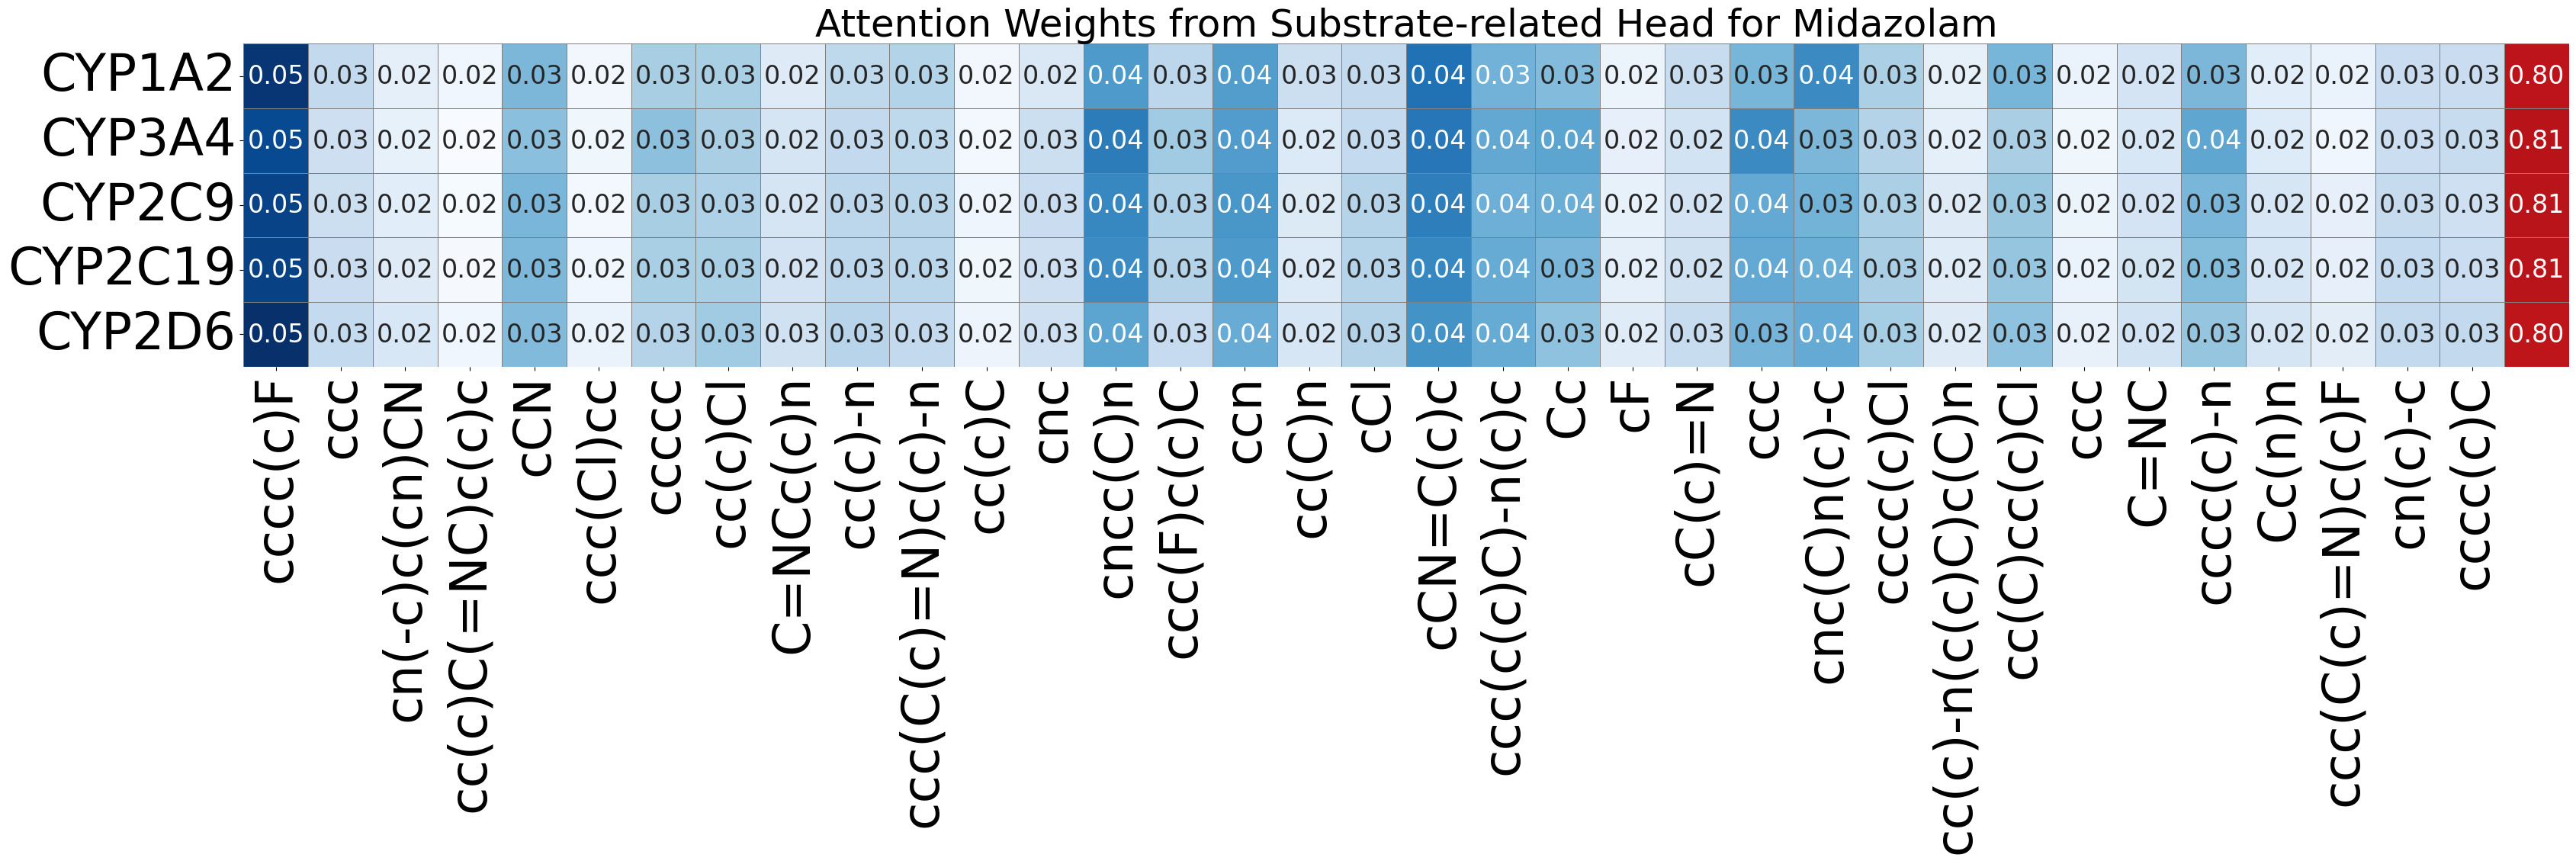

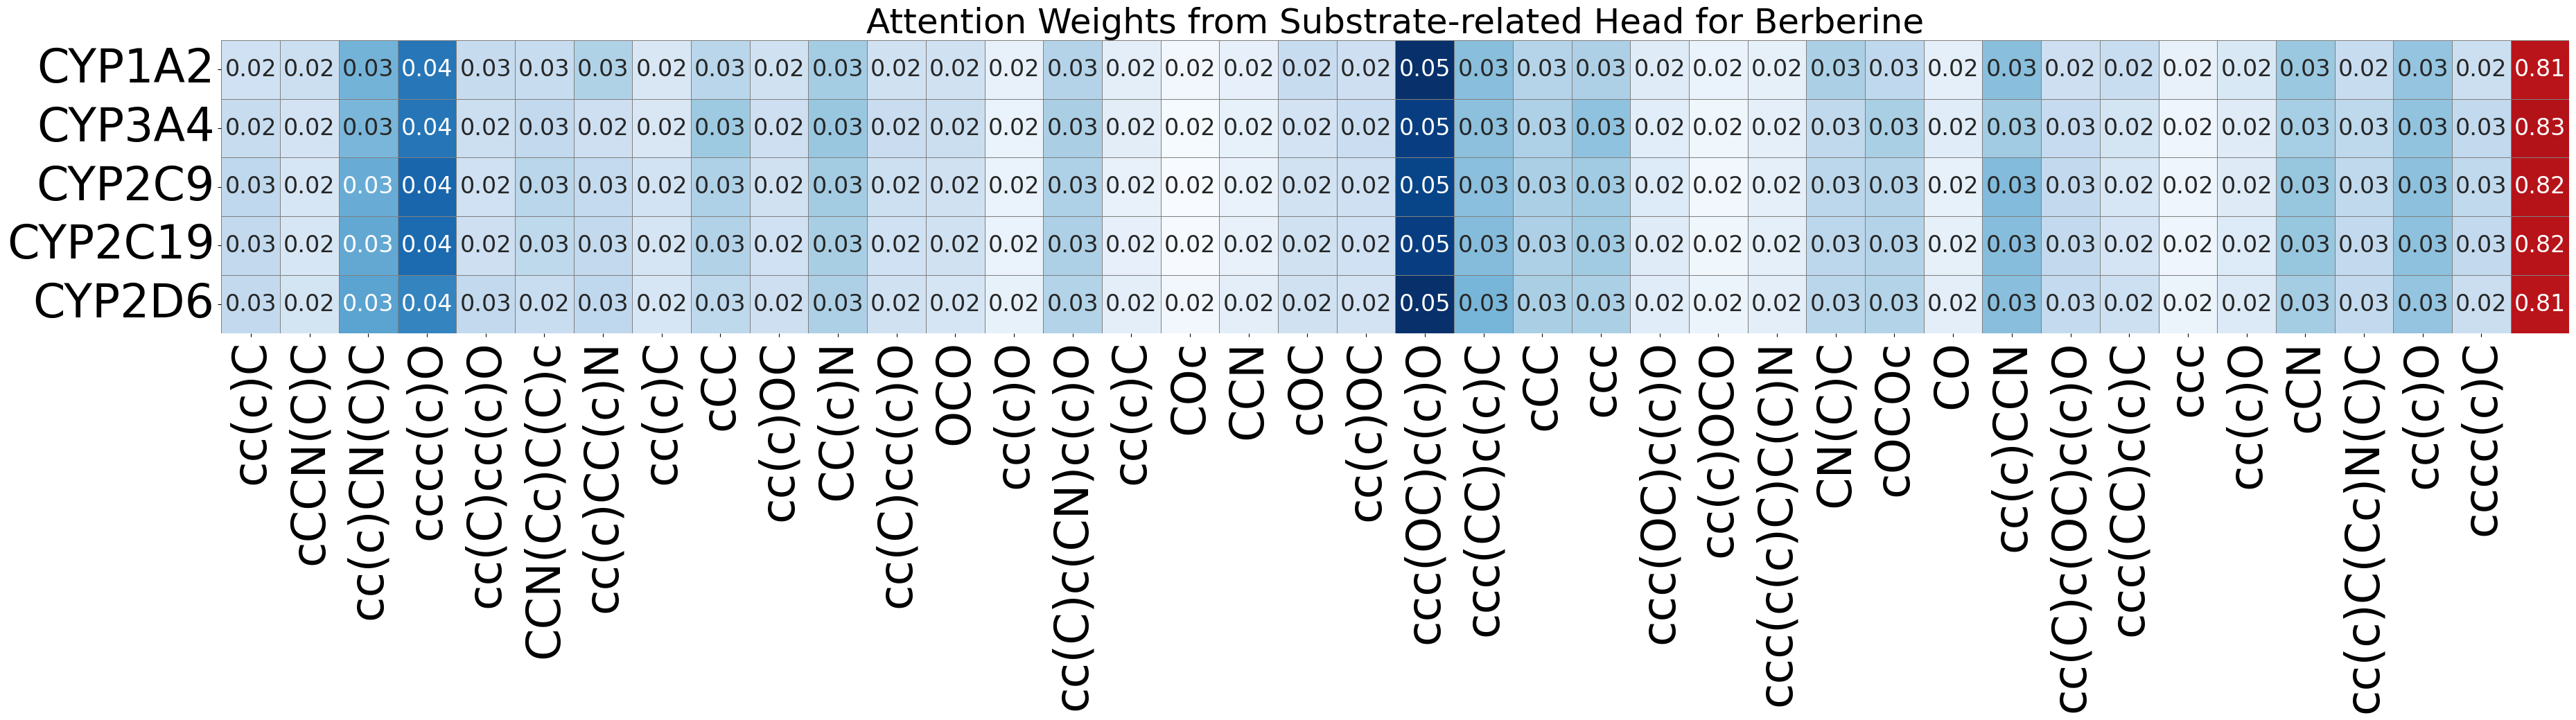

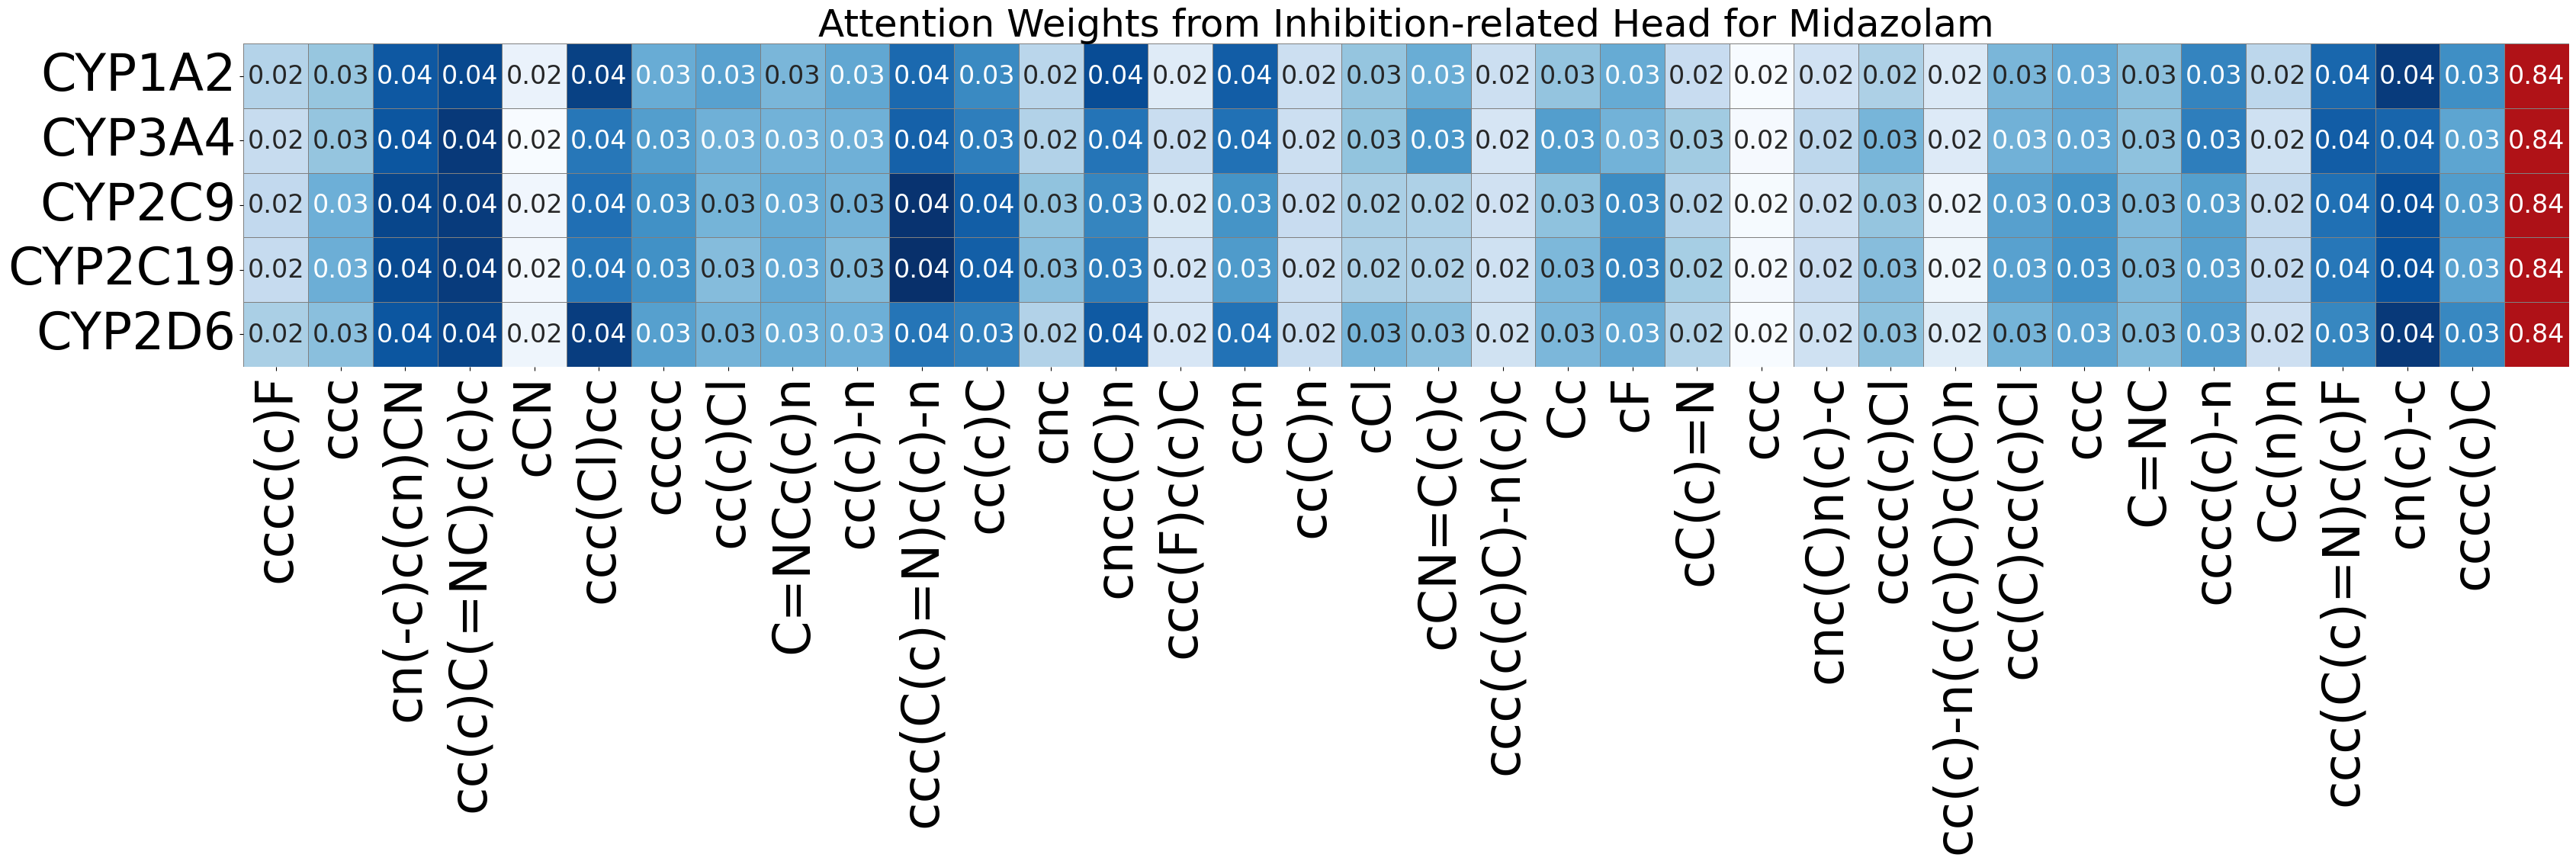

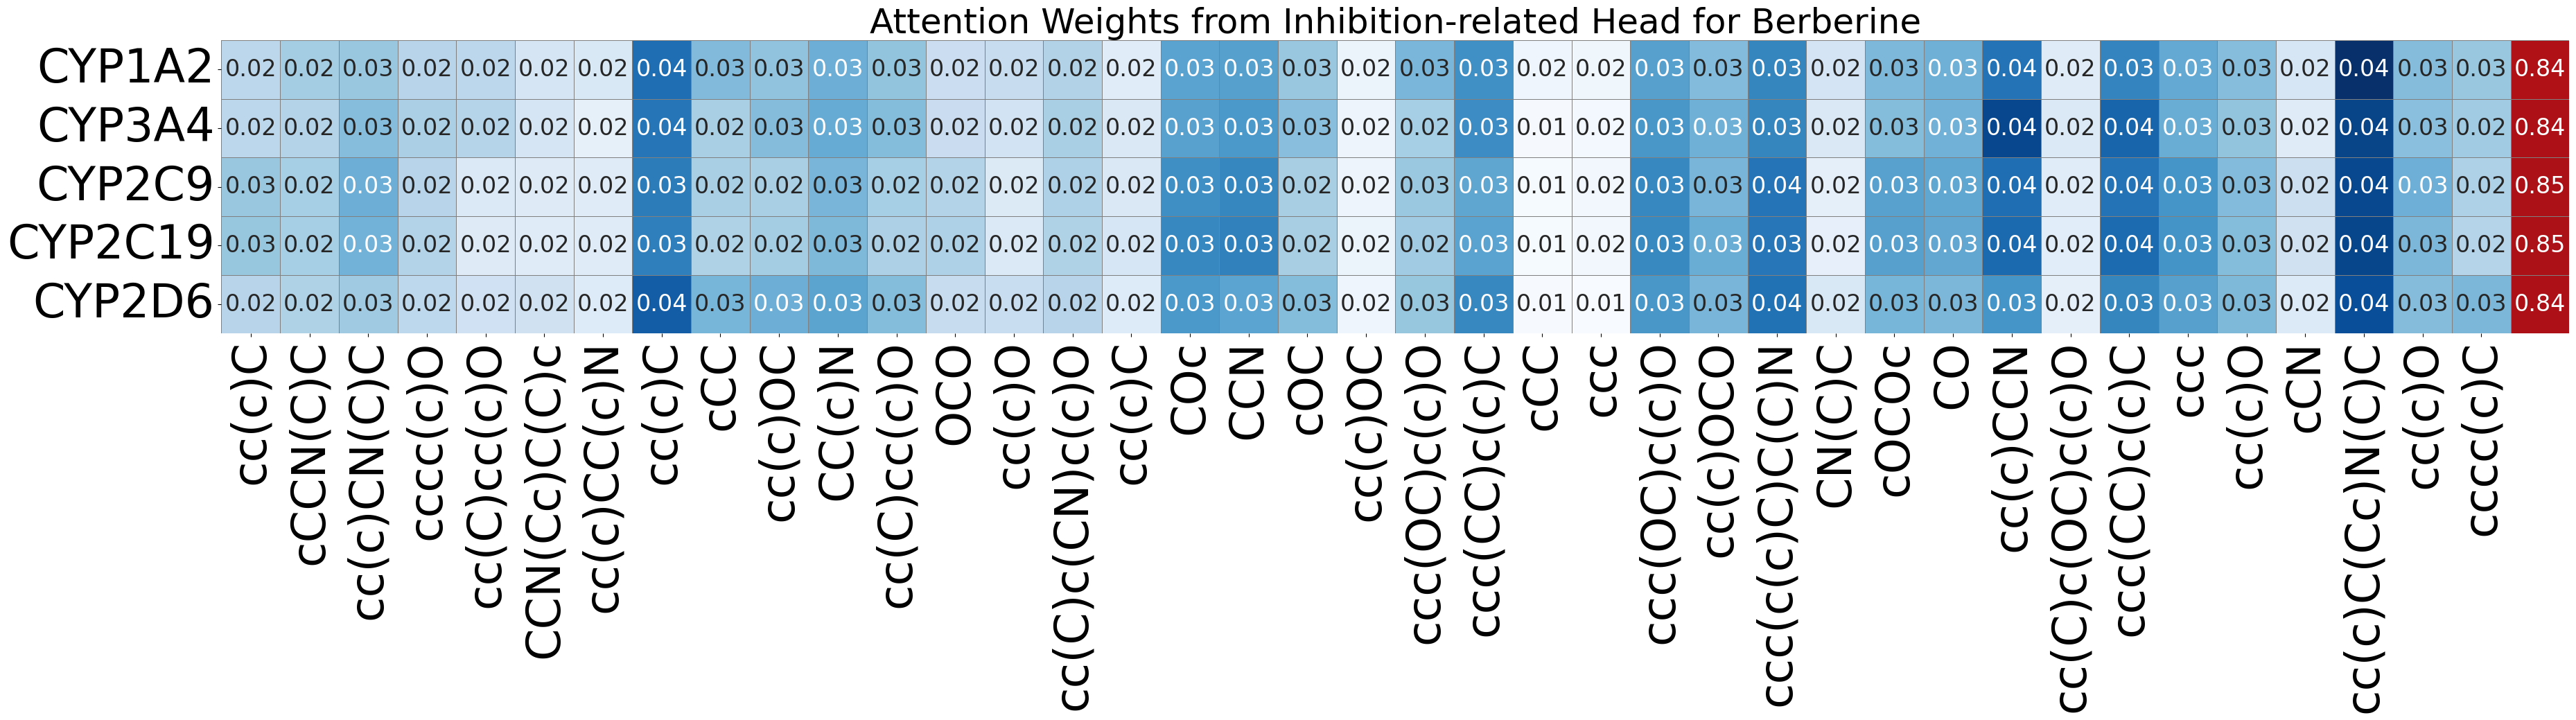

In [7]:
ext_drug_name   = 'Midazolam'
ext_drug_smiles = 'CC1=NC=C2N1C3=C(C=C(C=C3)Cl)C(=NC2)C4=CC=CC=C4F'

ext_food_name   = 'Berberine'
ext_food_smiles = 'COC1=C(C2=C(CC3C4=CC5=C(C=C4CCN3C2)OCO5)C=C1)OC'

dfi_analysis((ext_drug_name,ext_drug_smiles), (ext_food_name,ext_food_smiles))